In [1]:
import pyccl as ccl
import numpy as np
import pylab as plt

In [2]:
# Cosmology definition - adjusted to match blast one
h0 = 0.6727 #0.67
Ob = 0.0492 #071330589849
Odm= 0.2664 #19039780521262
As = 2.12107e-9
ns = 0.9645 #65

In [3]:
nofz = np.load("data/mynz.npy")
dndz = np.zeros((2,1000))
dndz[0,:] = nofz["z"]
dndz[1,:] = nofz["nz"]

In [4]:
# Cosmology
camb_params = {"camb": {"halofit_version": "takahashi"}}

cosmo = ccl.Cosmology(Omega_c=Odm, Omega_b=Ob, h=h0, A_s=As, n_s=ns, matter_power_spectrum='camb', extra_parameters=camb_params)

# Redshift-dependent functions
#z = np.linspace(0,1.2,1024)
z = np.linspace(0,5,1024)

# Redshift distributions
nz1 = np.interp(z,dndz[0],dndz[1]) #np.exp(-((z-0.5)/0.05)**2/2)
#nz2 = np.exp(-((z-0.65)/0.05)**2/2)

# Bias
#bz = 0.95/ccl|growth_factor(cosmo,1./(1+z))
bz = np.ones_like(z)

# Magnification bias
sz = np.zeros_like(z)
# Intrinsic alignment amplitude
#az = -0.004 * np.ones_like(z)

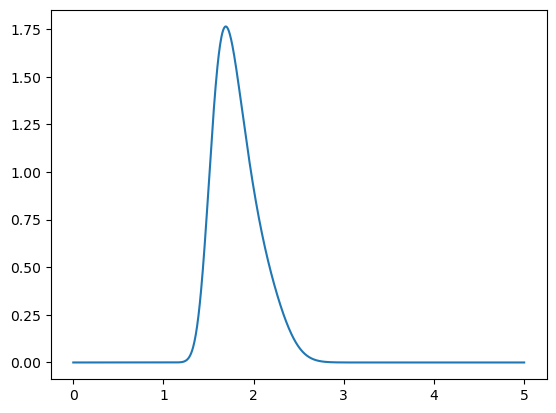

In [5]:
plt.plot(z, nz1)

In [6]:
cmbl = ccl.CMBLensingTracer(cosmo, z_source=1100.)
cclg = ccl.NumberCountsTracer(cosmo,dndz=(z,nz1),bias=(z,bz),has_rsd=False)
ccls = ccl.tracers.WeakLensingTracer(cosmo, dndz=(z,nz1))

Text(0.5, 1.0, 'CMB Lensing kernel')

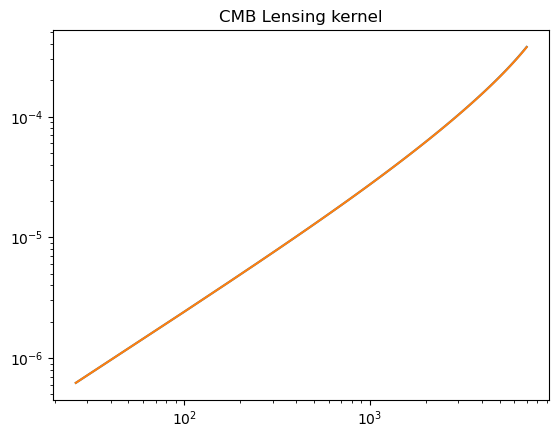

In [7]:
chi = np.linspace(26,7000, 96)
blast_cmb = np.load("data/cmb_kernel.npy")
plt.loglog(chi, blast_cmb)
plt.plot(chi, cmbl.get_kernel(chi)[0,:])
plt.title("CMB Lensing kernel")

Text(0.5, 1.0, 'Residuals')

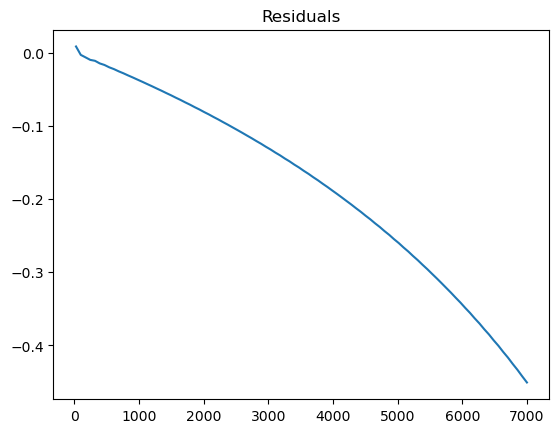

In [8]:
plt.plot(chi, 100*(1 - blast_cmb/cmbl.get_kernel(chi)[0,:]))
plt.title("Residuals")

chi_finer = np.linspace(0,8000, 2000)
np.savez("data/ccl_cmb_kernel_finer.npz", cmbl.get_kernel(chi_finer)[0,:])
np.savez("data/ccl_gal_kernel_finer.npz", cclg.get_kernel(chi_finer)[0,:])
np.savez("data/ccl_sh_kernel_finer.npz", ccls.get_kernel(chi_finer)[0,:])
np.savez("data/chi_finer.npz", chi_finer)

# Comparison plots

In [175]:
## Fkem
cls_gg = np.load("FKEM/outputs/fkem_clgg.npz")
cls_gs = np.load("FKEM/outputs/fkem_clgs.npz")
cls_ss = np.load("FKEM/outputs/fkem_clss.npz")
cls_kg = np.load("FKEM/outputs/fkem_clkg.npz")
cls_ks = np.load("FKEM/outputs/fkem_clks.npz")

#cls_gg_pure = np.load("FKEM/outputs/fkem_gg_pure.npz")["arr_0"]
#cls_gs_pure = np.load("FKEM/outputs/fkem_gs_pure.npz")["arr_0"]
#cls_ss_pure = np.load("FKEM/outputs/fkem_ss_pure.npz")["arr_0"]

l_fkem = cls_gg["ls"][cls_gg["ls"]<210]
gg_fkem = cls_gg["cls"][0][cls_gg["ls"]<210]
gs_fkem = cls_gs["cls"][0][cls_gg["ls"]<210]
ss_fkem = cls_ss["cls"][0][cls_gg["ls"]<210]
kg_fkem = cls_kg["cls"][0][cls_gg["ls"]<210]
ks_fkem = cls_ks["cls"][0][cls_gg["ls"]<210]

In [176]:
ell_list = np.load("data/ell_list.npy")
blast_gg = np.load("blast_cls/D_gg.npy")
blast_ss = np.load("blast_cls/D_ss.npy")
blast_gs = np.load("blast_cls/D_gs.npy")
blast_gcmbl = np.load("blast_cls/D_gcmbl.npy")
blast_scmbl = np.load("blast_cls/D_scmbl.npy")

In [177]:
brute_ell = np.array([2., 5., 10., 50., 100., 150., 200.])
gg_bf = np.load("brute_force/tot_Cl_gg.npy")
gs_bf = np.load("brute_force/tot_Cl_gs.npy")
ss_bf = np.load("brute_force/tot_Cl_ss.npy")
gk_bf = np.load("brute_force/tot_Cl_gk.npy")
sk_bf = np.load("brute_force/tot_Cl_sk.npy")

In [178]:
#ccells = np.linspace(2, 2000, 900) #spiky results
#ccells = np.arange(2, 2000) #more spiky results
ccells = np.unique(np.geomspace(2, 2000, 128).astype(int)).astype(float)

In [179]:
cl_gg_ccl = ccl.angular_cl(cosmo, cclg, cclg, ccells, l_limber=210, return_meta=True)[0]
cl_ss_ccl = ccl.angular_cl(cosmo, ccls, ccls, ccells, l_limber=210, return_meta=True)[0]
cl_gs_ccl = ccl.angular_cl(cosmo, cclg, ccls, ccells, l_limber=210, return_meta=True)[0]
cl_kg_ccl = ccl.angular_cl(cosmo, cmbl, cclg, ccells, l_limber=210, return_meta=True)[0]
cl_ks_ccl = ccl.angular_cl(cosmo, cmbl, cclg, ccells, l_limber=210, return_meta=True)[0]

Text(0.5, 1.0, 'galaxy-galaxy')

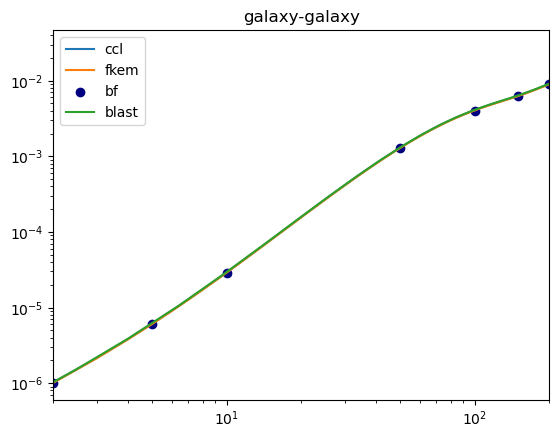

In [180]:
plt.plot(ccells, ccells * (ccells +1) * cl_gg_ccl, label="ccl" )
plt.loglog(l_fkem, l_fkem*(l_fkem+1)*(gg_fkem), label="fkem")
plt.scatter(brute_ell, brute_ell*(brute_ell+1)*gg_bf, label="bf", color="navy")
plt.plot(ell_list, blast_gg, label="blast")
plt.xlim((2,200))
plt.legend()
plt.title("galaxy-galaxy")

Text(0.5, 1.0, 'shear-shear')

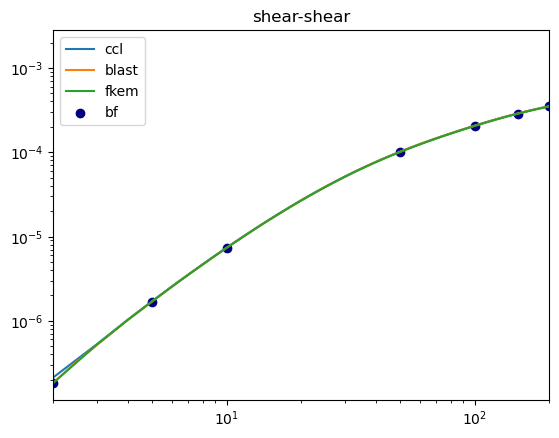

In [181]:
plt.plot(ccells, ccells * (ccells +1) * cl_ss_ccl, label="ccl" )
plt.loglog(ell_list, blast_ss, label="blast")
plt.plot(l_fkem, l_fkem*(l_fkem+1)*(ss_fkem), label="fkem")
plt.scatter(brute_ell, brute_ell*(brute_ell+1)*ss_bf, label="bf", color="navy")
plt.xlim(2,200)
plt.legend()
plt.title("shear-shear")

Text(0.5, 1.0, 'galaxy-galaxy lensing')

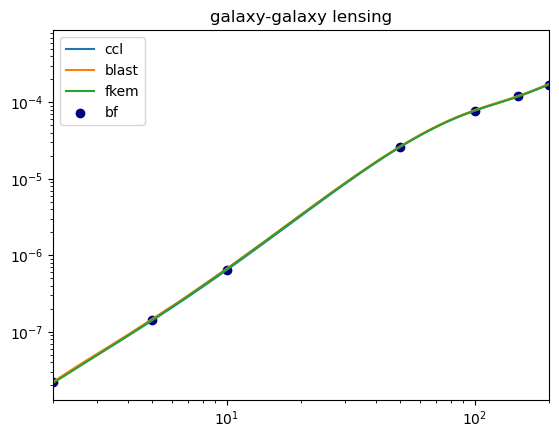

In [182]:
plt.plot(ccells, ccells * (ccells +1) * cl_gs_ccl, label="ccl" )
plt.loglog(ell_list, blast_gs, label="blast")
plt.plot(l_fkem, l_fkem*(l_fkem+1)*(gs_fkem), label="fkem")
plt.scatter(brute_ell, brute_ell*(brute_ell+1)*gs_bf, label="bf", color="navy")
plt.legend()
plt.xlim((2,200))
plt.title("galaxy-galaxy lensing")

Text(0.5, 1.0, 'galaxy-cmb lensing')

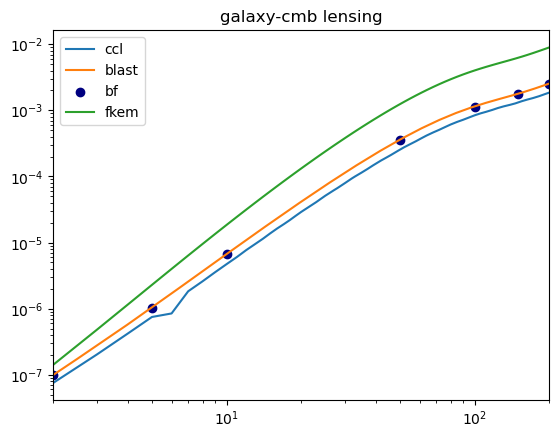

In [183]:
plt.loglog(ccells, (ccells * (ccells +1)) * cl_kg_ccl, label="ccl" )
plt.plot(ell_list, blast_gcmbl, label="blast")
plt.scatter(brute_ell, brute_ell*(brute_ell+1)*gk_bf, label="bf", color="navy")
plt.plot(l_fkem, l_fkem*(l_fkem+1)*(kg_fkem), label="fkem")
plt.legend()
plt.xlim((2,200))
plt.title("galaxy-cmb lensing")

Text(0.5, 1.0, 'shear-cmb lensing')

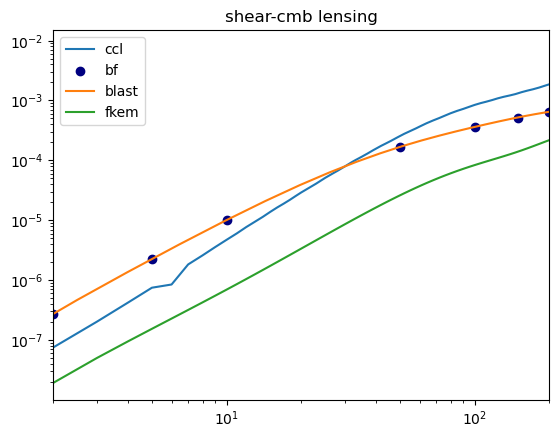

In [184]:
plt.loglog(ccells, (ccells * (ccells +1)) * cl_ks_ccl, label="ccl" )
plt.scatter(brute_ell, brute_ell*(brute_ell+1)*sk_bf, label="bf", color="navy")
plt.plot(ell_list, blast_scmbl, label="blast")
plt.plot(l_fkem, (l_fkem*(l_fkem+1))*(ks_fkem), label="fkem")
plt.legend()
plt.xlim((2,200))
plt.title("shear-cmb lensing")

### Power spectrum test

In [20]:
ccl_lin_pk = cosmo.get_linear_power()
ccl_nl_pk = cosmo.get_nonlin_power()

In [21]:
k = np.load("data/k_nl.npz")["arr_0"]
z = np.load("data/z_nl.npz")["arr_0"]
a = 1/(1+z)

In [22]:
pk_nl_camb = np.load("data/camb_nl_pk.npz")["arr_0"]

In [23]:
pk_lin_camb = np.load("data/camb_lin_pk.npz")["arr_0"]

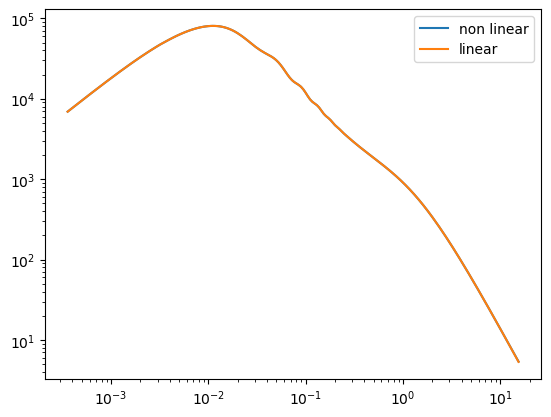

In [24]:
plt.loglog(k, ccl_nl_pk(k, a[0]), label = "non linear")
plt.loglog(k, pk_nl_camb[0,:], label = "linear")
plt.legend()

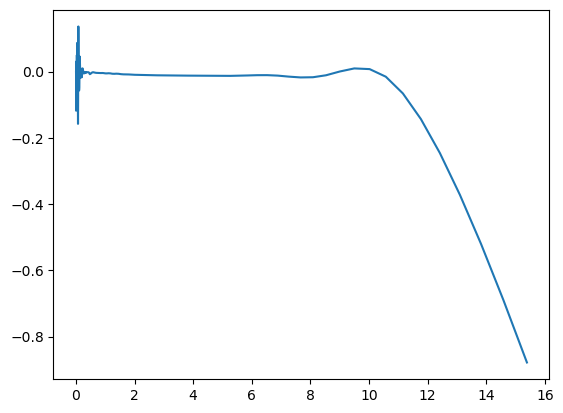

In [25]:
plt.plot(k, 100*(1-ccl_nl_pk(k, a[0])/pk_nl_camb[0,:]))

### Prepare elements for brute force computation

In [32]:
chi_finer = np.linspace(0,8000, 2000)
a_arr = ccl.scale_factor_of_chi(cosmo, chi_finer)
growfac_arr = ccl.growth_factor(cosmo, a_arr)

In [33]:
np.save("data/growth_finer.npy", growfac_arr)